### Задача

Уравнение Ван дер Поля - осциллятор с нелинейным затуханием  
$$
\frac{d^2 y}{dt^2} + a(y^2 - 1) \frac{dy}{dt} + y = 0, \quad y(0) = y_0 > 0, \quad y'(0) = 0, \quad 0 \leq t \leq 30, \quad 1 \leq a \leq 1000.
$$

1. Исследовать зависимость численных решений от параметров процессов;  
2. Исследовать сходимость численного решения по сетке;  
3. Использовать явный и неявный методы Рунге-Кутты 4-го порядка точности;  
4. Построить фазовый портрет.

In [228]:
# Используемые библиотеки
import numpy as np
import matplotlib.pyplot as plt
import functools

Перепишем уравнение Ван дер Поля в виде системы:
$$
\begin{equation*}
    \begin{cases}
      \frac{dy}{dt} = x \\
      \frac{dx}{dt} = a(1 - y^2) x - y
    \end{cases}\,.
\end{equation*}
$$

In [229]:
# Уравнение Ван дер Поля
def van_der_pol(xy_vec, t, a):
    y, x = xy_vec
    dydt = [x, a * (1 - y**2) * x - y]
    return dydt

Метод Рунге-Кутты четвёртого порядка:
$$ k_1 = h f(t_n, u_n), $$
$$ k_2 = h f(t_n + \frac{h}{2}, u_n + \frac{k_1}{2}), $$
$$ k_3 = h f(t_n + \frac{h}{2}, u_n + \frac{k_2}{2}), $$
$$ k_4 = h f(t_n + h, u_n + k_3), $$
$$ u_{n+1} = u_n + \frac{k_1 + 2k_2 + 2k_3 + k_4}{6}. $$

In [230]:
# Явный метод Рунге-Кутты 4-го порядка
def rk4_method(f, xy_vec0, t):
    N = len(t)
    try:
        n = len(xy_vec0)
    except TypeError:
        n = 1
    xy_vec = np.zeros((N, n))
    xy_vec[0] = xy_vec0

    for i in range(N - 1):
        h = t[i + 1] - t[i]
        k1 = np.array(f(xy_vec[i], t[i]))
        k2 = np.array(f(xy_vec[i] + h / 2 * k1, t[i] + h / 2))
        k3 = np.array(f(xy_vec[i] + h / 2 * k2, t[i] + h / 2))
        k4 = np.array(f(xy_vec[i] + h * k3, t[i] + h))
        xy_vec[i + 1] = xy_vec[i] + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    return xy_vec

In [ ]:
# Построение фазового портрета
def generate_phase_portrait(y, a):
    plt.plot(y[:, 0], y[:, 1], label=f'a = {a}')
    plt.title('Фазовый портрет уравнения Ван дер Поля')
    plt.xlabel('y')
    plt.ylabel("y'")
    plt.legend()
    plt.grid(True)
    plt.show()

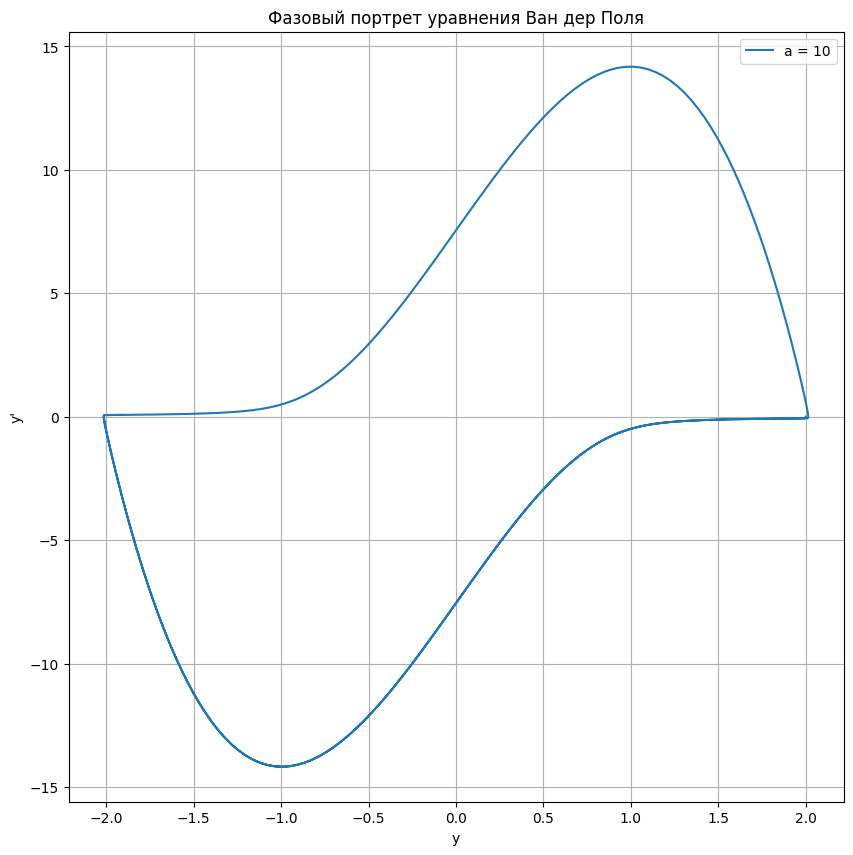

In [251]:
# Начальные условия (y(0) = y_0 > 0, y'(0) = 0)
xy_vec0 = [2.0, 0.0]

# Параметр a
a_value = 10
van_der_pol_a = functools.partial(van_der_pol, a = a_value)

# Сетка
t = np.linspace(0, 30, 10000)

y = rk4_method(van_der_pol_a, xy_vec0, t)

generate_phase_portrait(y, a_value)

Исследуем зависимость численных решений от параметров процессов для явного метода Рунге-Кутты:

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 100: 1.7794315698758116
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 90: 1.7516431623556066
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 80: 1.7156392416481956
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 70: 1.6669634983753798
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 60: 1.5969229033482637
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 50: 1.4849057585657512
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 40: 1.2491596391754032
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 30: -1.890134914108069
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 20: -1.4447861788090957
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 10: -1.9065895374892148


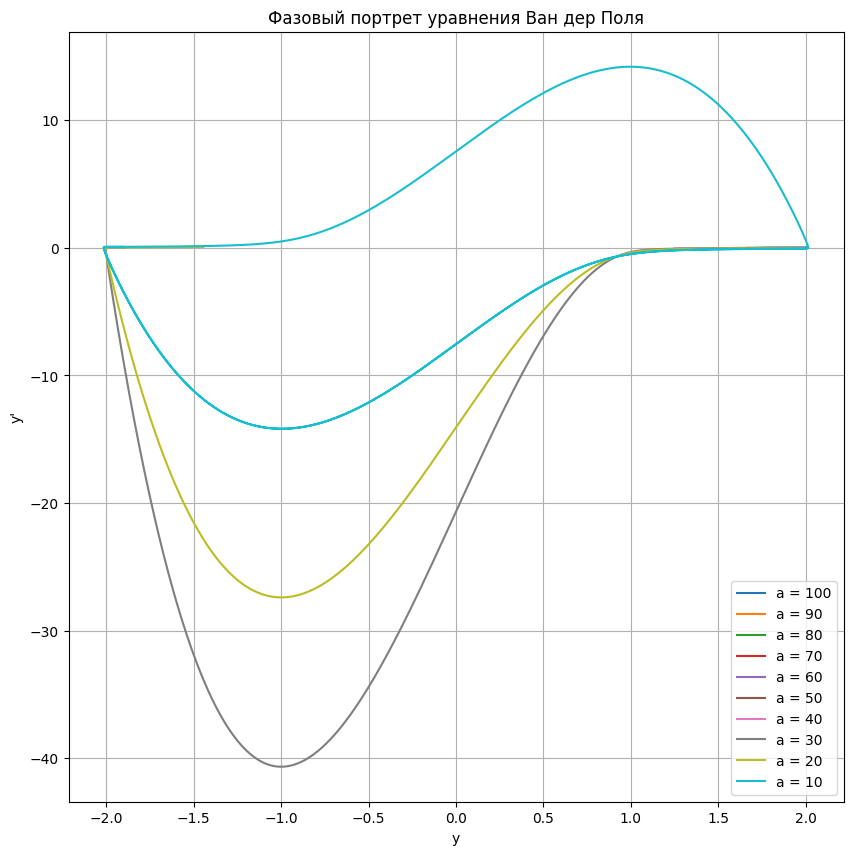

In [ ]:
# Сетка
t = np.linspace(0, 30, 100000)

plt.figure(figsize=(10, 10))

for a_value in range(100, 1, -10):
    van_der_pol_a = functools.partial(van_der_pol, a = a_value)

    y = rk4_method(van_der_pol_a, xy_vec0, t)
    plt.plot(y[:, 0], y[:, 1], label=f'a = {a_value}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    

plt.title('Фазовый портрет уравнения Ван дер Поля')
plt.legend()
plt.xlabel('y')
plt.ylabel("y'")
plt.legend()
plt.grid(True)
plt.show()

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: 1.8095508236623248


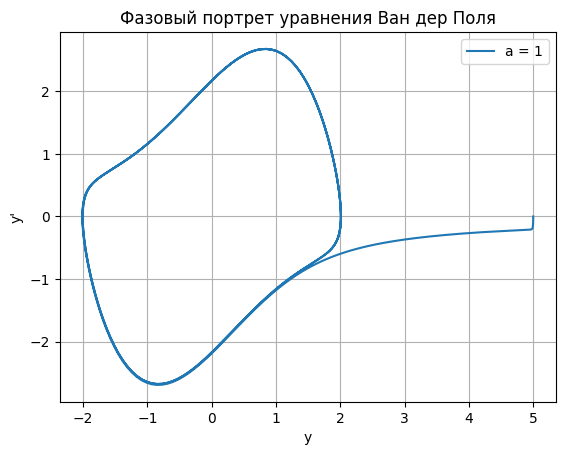

In [249]:
a_value = 1

# Сетка
t = np.linspace(0, 30, 1000)

van_der_pol_a = functools.partial(van_der_pol, a = a_value)
xy_vec0 = [5, 0.0]

y = rk4_method(van_der_pol_a, xy_vec0, t)
plt.plot(y[:, 0], y[:, 1], label=f'a = {a_value}')
print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    

plt.title('Фазовый портрет уравнения Ван дер Поля')
plt.legend()
plt.xlabel('y')
plt.ylabel("y'")
plt.legend()
plt.grid(True)
plt.show()

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: 0.0
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: -2.007910429467446
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: -1.054311580008789
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: 0.4855748397189655
> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: 1.0135198966351024


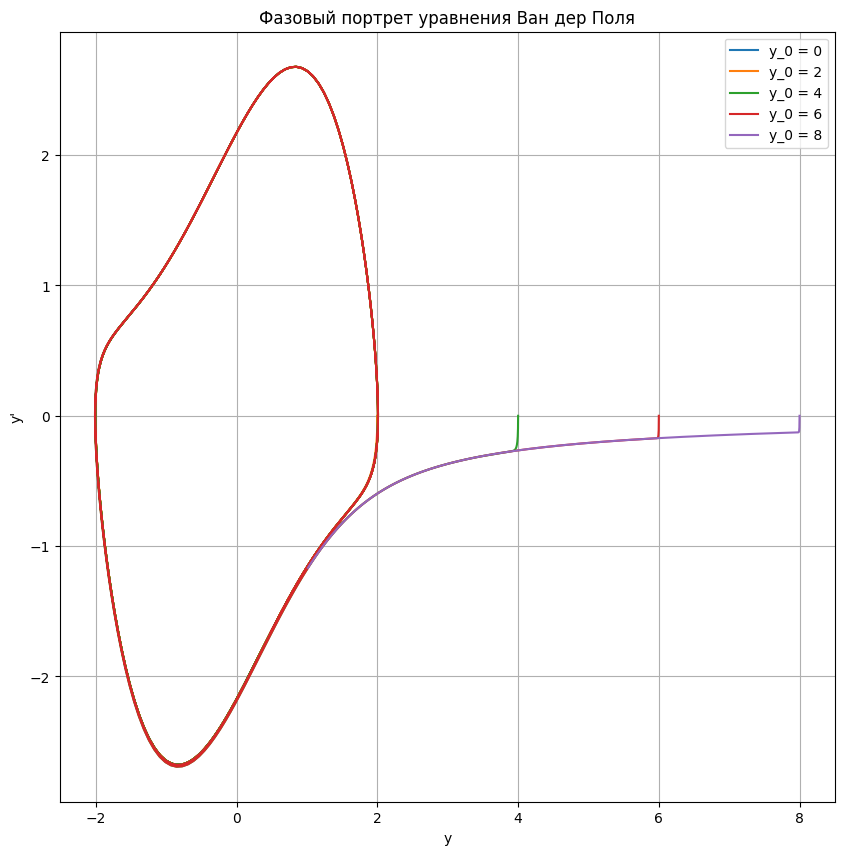

> Решение, найденное методом Рунге-Кутты четвертого порядка для a = 1: 1.8095508236623248


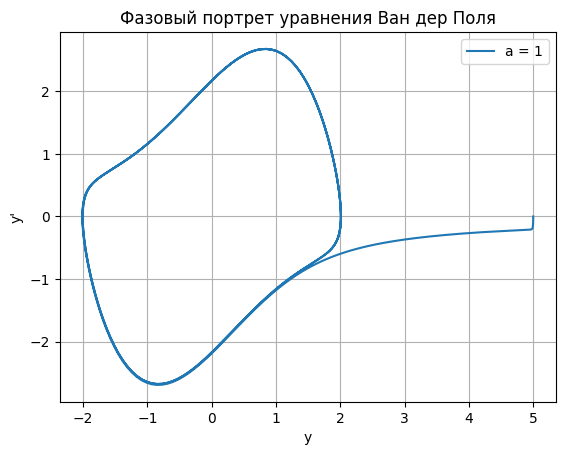

In [ ]:
a_value = 1

# Сетка
t = np.linspace(0, 30, 1000)

plt.figure(figsize=(10, 10))

for y_0 in range(0, 10, 2):
    van_der_pol_a = functools.partial(van_der_pol, a = a_value)
    xy_vec0 = [y_0, 0.0]

    y = rk4_method(van_der_pol_a, xy_vec0, t)
    plt.plot(y[:, 0], y[:, 1], label=f'y_0 = {y_0}')
    print(f"> Решение, найденное методом Рунге-Кутты четвертого порядка для a = {a_value}: {y[-1, 0]}")
    

plt.title('Фазовый портрет уравнения Ван дер Поля')
plt.legend()
plt.xlabel('y')
plt.ylabel("y'")
plt.legend()
plt.grid(True)
plt.show()